## Hello everyone
#### Thank you for viewing this kernel. With the use of various data preprocessing techniques as well as various machine learning algorithms, I was able to build various models in a bid to predict mosquitoes test results (negative or positive). The dataset used is "Chicago West Nile Virus Mosquito Test Results" maintained by kaggle.com. Have a look and share your thoughts on this. Thank you again!

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import scipy.stats as st
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from mlxtend.plotting import plot_confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score

pd.set_option('display.max_rows', 10)



# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['west-nile-virus-wnv-mosquito-test-results.csv', 'socrata_metadata.json']


Fetching the data using pandas 

In [2]:
wnvData = pd.read_csv("../input/west-nile-virus-wnv-mosquito-test-results.csv")

Exploring the datatypes of the dataframe variables

In [3]:
wnvData.dtypes

SEASON YEAR                     int64
WEEK                            int64
TEST ID                         int64
BLOCK                          object
TRAP                           object
                               ...   
Wards                         float64
Census Tracts                 float64
Zip Codes                     float64
Community Areas               float64
Historical Wards 2003-2015    float64
Length: 18, dtype: object

In [4]:
wnvData.head()

,SEASON YEAR,WEEK,TEST ID,BLOCK,TRAP,TRAP_TYPE,TEST DATE,NUMBER OF MOSQUITOES,RESULT,SPECIES,LATITUDE,LONGITUDE,LOCATION,Wards,Census Tracts,Zip Codes,Community Areas,Historical Wards 2003-2015
0,2019,27,48404,79XX S CHICAGO,T083,GRAVID,2019-07-03T00:07:00.000,3,negative,CULEX PIPIENS/RESTUANS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019,27,48423,127XX S DOTY AVE,T115,GRAVID,2019-07-03T00:07:00.000,1,negative,CULEX TERRITANS,41.662387,-87.590180,"{'human_address': '{""address"": """", ""city"": """",...",47.0,174.0,22250.0,48.0,47.0
2,2019,27,48367,25XX W GRAND AVE,T046,GRAVID,2019-07-03T00:07:00.000,38,negative,CULEX RESTUANS,41.892220,-87.691698,"{'human_address': '{""address"": """", ""city"": """",...",46.0,177.0,21184.0,24.0,41.0
3,2019,27,48365,1XX N CENTRAL PARK DR,T030B,SENTINEL,2019-07-03T00:07:00.000,4,negative,CULEX RESTUANS,41.883711,-87.716092,"{'human_address': '{""address"": """", ""city"": """",...",23.0,176.0,21572.0,28.0,11.0
4,2019,27,48323,100XX W OHARE AIRPORT,T900,GRAVID,2019-07-03T00:07:00.000,1,negative,CULEX RESTUANS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
wnvData.shape

(27893, 18)

In [6]:
wnvData.describe()

,SEASON YEAR,WEEK,TEST ID,NUMBER OF MOSQUITOES,LATITUDE,LONGITUDE,Wards,Census Tracts,Zip Codes,Community Areas,Historical Wards 2003-2015
count,27893.000000,27893.000000,27893.000000,27893.000000,23696.000000,23696.000000,23696.000000,23696.000000,23696.000000,23696.000000,23696.000000
mean,2012.130212,30.939340,34350.553580,12.431219,41.835823,-87.687918,28.825076,406.742657,19852.986411,42.176612,31.681381
std,3.568425,4.552975,8169.922598,15.381698,0.113180,0.076914,14.514139,244.992196,5221.521224,21.165821,13.787604
min,2007.000000,20.000000,20000.000000,1.000000,41.644720,-87.854473,1.000000,6.000000,4299.000000,4.000000,1.000000
25%,2009.000000,27.000000,27314.000000,2.000000,41.731447,-87.745420,19.000000,176.000000,21202.000000,24.000000,20.000000
50%,2012.000000,31.000000,34328.000000,5.000000,41.825398,-87.689417,29.000000,391.000000,21861.000000,48.000000,34.000000
75%,2015.000000,34.000000,41438.000000,16.000000,41.945961,-87.632955,42.000000,637.000000,22254.000000,61.000000,45.000000
max,2019.000000,40.000000,48431.000000,77.000000,42.017801,-87.531060,50.000000,787.000000,22620.000000,77.000000,53.000000


In [7]:
wnvData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27893 entries, 0 to 27892
Data columns (total 18 columns):
SEASON YEAR                   27893 non-null int64
WEEK                          27893 non-null int64
TEST ID                       27893 non-null int64
BLOCK                         27893 non-null object
TRAP                          27893 non-null object
TRAP_TYPE                     27893 non-null object
TEST DATE                     27893 non-null object
NUMBER OF MOSQUITOES          27893 non-null int64
RESULT                        27893 non-null object
SPECIES                       27893 non-null object
LATITUDE                      23696 non-null float64
LONGITUDE                     23696 non-null float64
LOCATION                      23696 non-null object
Wards                         23696 non-null float64
Census Tracts                 23696 non-null float64
Zip Codes                     23696 non-null float64
Community Areas               23696 non-null float64
Histo

Let's see if there are missing values in the dataset

In [8]:
wnvData.isnull().values.any()


True

Now we know we do, let's see where they are and how many are present

In [9]:
wnvData.isnull().sum()

SEASON YEAR                      0
WEEK                             0
TEST ID                          0
BLOCK                            0
TRAP                             0
                              ... 
Wards                         4197
Census Tracts                 4197
Zip Codes                     4197
Community Areas               4197
Historical Wards 2003-2015    4197
Length: 18, dtype: int64

In [10]:
wnvData.columns.values

array(['SEASON YEAR', 'WEEK', 'TEST ID', 'BLOCK', 'TRAP', 'TRAP_TYPE',
       'TEST DATE', 'NUMBER OF MOSQUITOES', 'RESULT', 'SPECIES',
       'LATITUDE', 'LONGITUDE', 'LOCATION', 'Wards', 'Census Tracts',
       'Zip Codes', 'Community Areas', 'Historical Wards 2003-2015'],
      dtype=object)

Let's fetch all the columns with object datatypes as well as drop the irrelvant columns in this mix

In [11]:
s = (wnvData.dtypes == 'object')
object_cols = list(s[s].index)

print("Categorical variables:")
print(object_cols)

Categorical variables:
['BLOCK', 'TRAP', 'TRAP_TYPE', 'TEST DATE', 'RESULT', 'SPECIES', 'LOCATION']


In [12]:


wnvData.drop( wnvData.columns [[3,12, 4, 6]], axis=1, inplace=True)

#wnvData.drop( wnvData.columns ["BLOCK, "LOCATION", 'TRAP', 'TEST DATE'], axis=1, inplace=True)

In [13]:
s = (wnvData.dtypes == 'object')
object_cols = list(s[s].index)

print("Categorical variables:")
print(object_cols)

Categorical variables:
['TRAP_TYPE', 'RESULT', 'SPECIES']


In [14]:
wnvData.head()

,SEASON YEAR,WEEK,TEST ID,TRAP_TYPE,NUMBER OF MOSQUITOES,RESULT,SPECIES,LATITUDE,LONGITUDE,Wards,Census Tracts,Zip Codes,Community Areas,Historical Wards 2003-2015
0,2019,27,48404,GRAVID,3,negative,CULEX PIPIENS/RESTUANS,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019,27,48423,GRAVID,1,negative,CULEX TERRITANS,41.662387,-87.590180,47.0,174.0,22250.0,48.0,47.0
2,2019,27,48367,GRAVID,38,negative,CULEX RESTUANS,41.892220,-87.691698,46.0,177.0,21184.0,24.0,41.0
3,2019,27,48365,SENTINEL,4,negative,CULEX RESTUANS,41.883711,-87.716092,23.0,176.0,21572.0,28.0,11.0
4,2019,27,48323,GRAVID,1,negative,CULEX RESTUANS,NaN,NaN,NaN,NaN,NaN,NaN,NaN


With the use of LabelEncoder, we can transform all the object datatype into a categorical variables says Result from Negative to 0 and Positive to 1

In [15]:
from sklearn import preprocessing 
le = preprocessing.LabelEncoder()

le.fit(wnvData['RESULT'])
wnvData['RESULT'] = le.transform(wnvData['RESULT'])

le.fit(wnvData['TRAP_TYPE'])
wnvData['TRAP_TYPE'] = le.transform(wnvData['TRAP_TYPE'])

le.fit(wnvData['SPECIES'])
wnvData['SPECIES'] = le.transform(wnvData['SPECIES'])


With the use of heatmap, let's inspect the correlation between all the variables

In [16]:
def plot_corr (wnvData, size =14):
    corr =wnvData.corr()
    fig, ax= plt.subplots(figsize =(size,size))
    ax.matshow(corr)
    plt.xticks(range(len(corr.columns)), corr.columns)     #draw x tick marks
    plt.yticks(range(len(corr.columns)), corr.columns) 

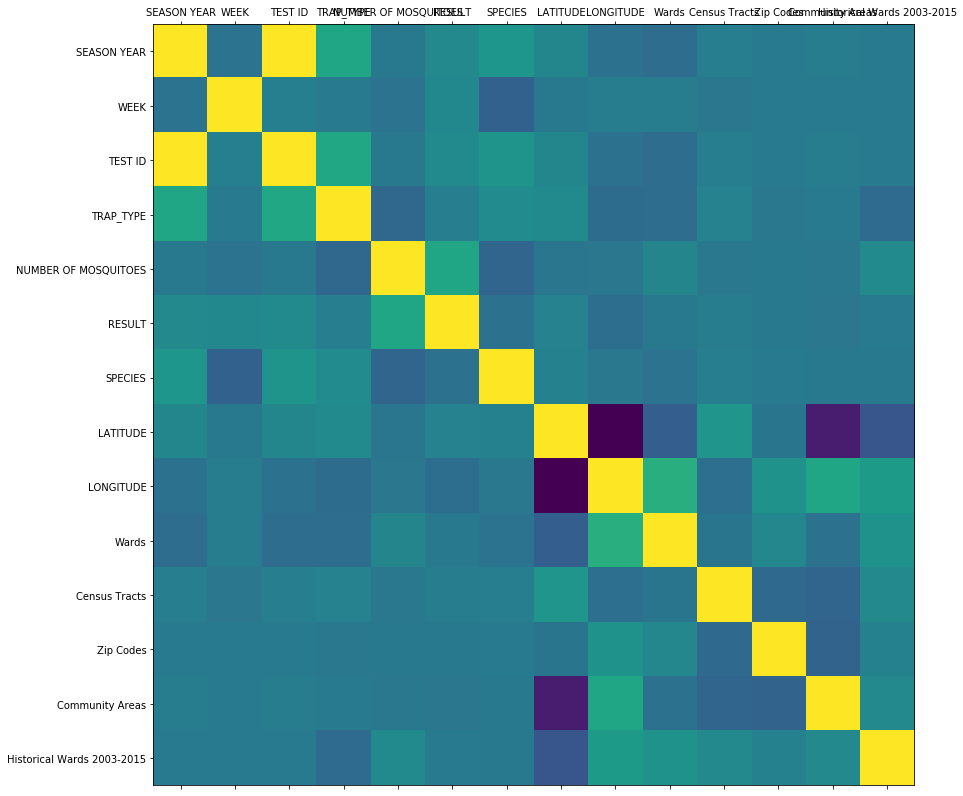

In [17]:
plot_corr(wnvData)

From the heatmap, there is a high correlation between SeasonYear and Test ID. we will drop Test ID

In [18]:
wnvData.drop( wnvData.columns [[2]], axis=1, inplace=True)

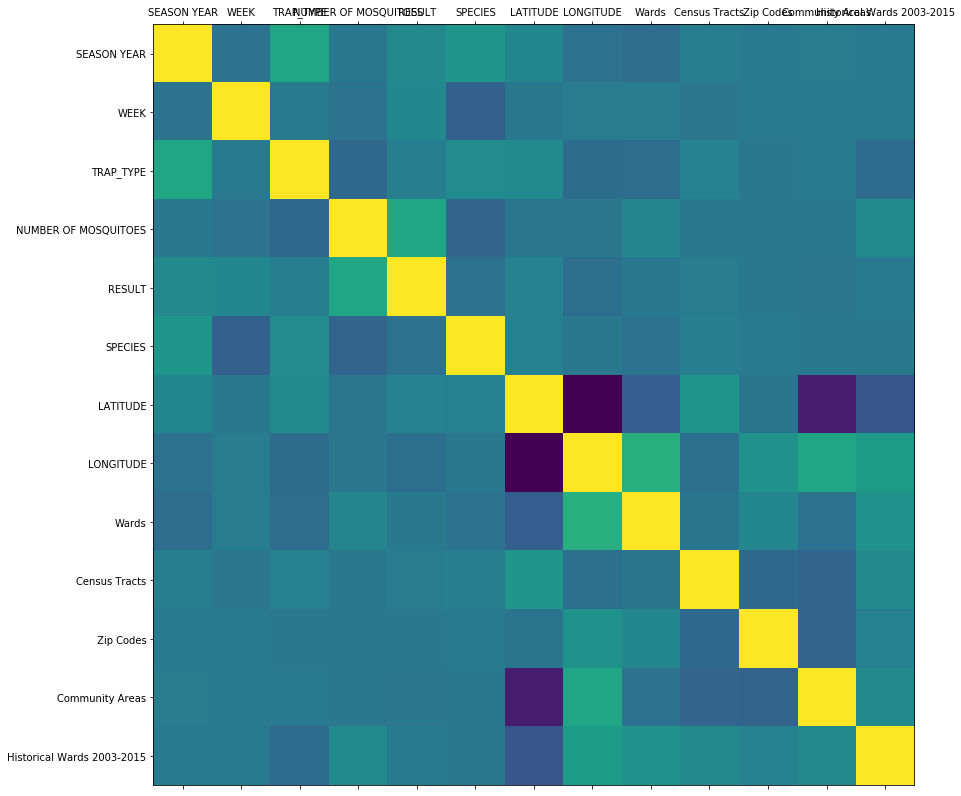

In [19]:
plot_corr(wnvData)

In [20]:
feature_col_name = [ 'SEASON YEAR', 'WEEK', 'SPECIES', 'TRAP_TYPE',
       'NUMBER OF MOSQUITOES', 'Wards', 'Census Tracts', 
       'Community Areas', 'Historical Wards 2003-2015']
predicted_class_name= [ 'RESULT']

X = wnvData[feature_col_name].values
y = wnvData[predicted_class_name].values
split_test_size = 0.1

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=split_test_size, random_state=42)

Let's handle the missing values in the train and test data set by using SimpleImputer function. You can learn more by visiting this link https://www.kaggle.com/alexisbcook/missing-values

In [21]:
from sklearn.impute import SimpleImputer

my_imputer = SimpleImputer()
X_train = my_imputer.fit_transform(X_train)
X_test = my_imputer.transform(X_test)

In [22]:
wnvData.head()

,SEASON YEAR,WEEK,TRAP_TYPE,NUMBER OF MOSQUITOES,RESULT,SPECIES,LATITUDE,LONGITUDE,Wards,Census Tracts,Zip Codes,Community Areas,Historical Wards 2003-2015
0,2019,27,1,3,0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019,27,1,1,0,6,41.662387,-87.590180,47.0,174.0,22250.0,48.0,47.0
2,2019,27,1,38,0,3,41.892220,-87.691698,46.0,177.0,21184.0,24.0,41.0
3,2019,27,3,4,0,3,41.883711,-87.716092,23.0,176.0,21572.0,28.0,11.0
4,2019,27,1,1,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
wnvData['RESULT'].value_counts()

0    25555
1     2338
Name: RESULT, dtype: int64

In [24]:
# Writing a function to automate fitting the classifiers and evaluate the algorithms

def classifier(model,train_independent,train_dependent,test_independent,true):
    model.fit(train_independent,train_dependent)
    prediction = model.predict(X_test)
    print(classification_report(true,prediction))
    
    # Confusion Matrix plot
    
    cm = confusion_matrix(y_test,prediction)
    fig= plot_confusion_matrix(conf_mat=cm,figsize=(4,4),cmap=plt.cm.Reds,hide_spines=True)
    plt.title('Confusion Matrix',fontsize=14)
    plt.xlabel('Predicted Values')
    plt.ylabel('Actual Values')
    plt.grid('off')
    plt.show()


    # 10-fold Cross Validation
    accuracies = cross_val_score(estimator= model,X= X_train,y=y_train,cv=10)
    print("The average model accuracy score is : %s" % "{0:.2%}".format(accuracies.mean()))
    print("The average accuracy score standard deviation is : %s" % "{0:.3%}".format(accuracies.std()))
    
    # Values of the ROC Curve as a probabilistic approach to classification
    roc_predict = model.predict_proba(X_test)
    roc_predict = [p[1] for p in roc_predict]
    area = roc_auc_score(y_test,roc_predict)
    float(area)
    print ("The area under the Reciver Operating Characteristic curve is: ", (round(area,2)))

## We will start the process by introducing LogisticRegression algorithm

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


              precision    recall  f1-score   support

           0       0.92      1.00      0.96      2570
           1       0.42      0.02      0.04       220

    accuracy                           0.92      2790
   macro avg       0.67      0.51      0.50      2790
weighted avg       0.88      0.92      0.89      2790



/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


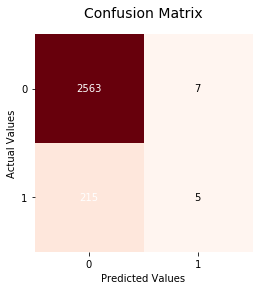

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:43

The average model accuracy score is : 91.36%
The average accuracy score standard deviation is : 0.177%
The area under the Reciver Operating Characteristic curve is:  0.8


In [25]:

from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression()
classifier(log_reg,X_train,y_train,X_test,y_test)

## How about Decision Tree algorithm?

              precision    recall  f1-score   support

           0       0.95      0.94      0.95      2570
           1       0.37      0.38      0.37       220

    accuracy                           0.90      2790
   macro avg       0.66      0.66      0.66      2790
weighted avg       0.90      0.90      0.90      2790



/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


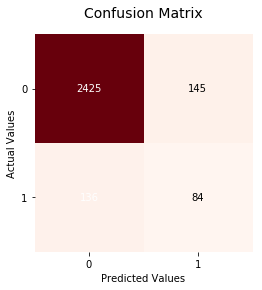

The average model accuracy score is : 88.95%
The average accuracy score standard deviation is : 0.503%
The area under the Reciver Operating Characteristic curve is:  0.7


In [26]:
from sklearn.tree import DecisionTreeClassifier
dtree = DecisionTreeClassifier()
classifier (dtree,X_train,y_train,X_test,y_test)

## ..... Random Forest Please!

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


              precision    recall  f1-score   support

           0       0.94      0.98      0.96      2570
           1       0.61      0.29      0.39       220

    accuracy                           0.93      2790
   macro avg       0.78      0.64      0.68      2790
weighted avg       0.92      0.93      0.92      2790



/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


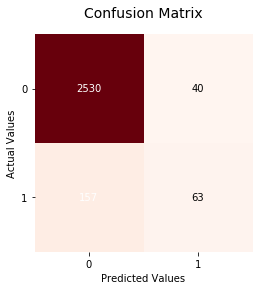

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 

The average model accuracy score is : 92.10%
The average accuracy score standard deviation is : 0.501%
The area under the Reciver Operating Characteristic curve is:  0.87


In [27]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=50)
classifier(rfc,X_train,y_train,X_test,y_test)

## KNeighbors were invited!

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  after removing the cwd from sys.path.
/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


              precision    recall  f1-score   support

           0       0.93      0.99      0.96      2570
           1       0.59      0.13      0.22       220

    accuracy                           0.92      2790
   macro avg       0.76      0.56      0.59      2790
weighted avg       0.90      0.92      0.90      2790



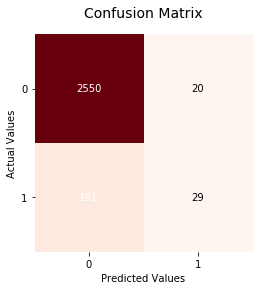

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when

The average model accuracy score is : 92.06%
The average accuracy score standard deviation is : 0.345%
The area under the Reciver Operating Characteristic curve is:  0.82


In [28]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=20)
classifier(knn, X_train,y_train,X_test,y_test)

## .... Finally we will use XGBooster

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


              precision    recall  f1-score   support

           0       0.94      0.99      0.97      2570
           1       0.75      0.24      0.36       220

    accuracy                           0.93      2790
   macro avg       0.84      0.62      0.66      2790
weighted avg       0.92      0.93      0.92      2790



/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


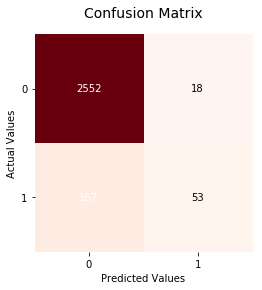

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for 

The average model accuracy score is : 92.60%
The average accuracy score standard deviation is : 0.362%
The area under the Reciver Operating Characteristic curve is:  0.89


In [29]:

# Importing the libraries for the XGBoost algorithm

from xgboost import XGBClassifier
xgb_classifier = XGBClassifier()
classifier(xgb_classifier,X_train,y_train,X_test,y_test)

## Let's make an attempt to cross validate our models

In [30]:

Model_Scores ={'Logistic Regression':{'10 Fold Cross Validation Score':
                                      "{0:.2%}".format((cross_val_score(estimator= log_reg,X= X_train,y=y_train,cv=10)).mean()), 
                                      'Standard Deviation':"{0:.2%}".format((cross_val_score(estimator= log_reg,X= X_train,y=y_train,cv=10)).std())},
                'Decision Trees':{'10 Fold Cross Validation Score':"{0:.2%}".format((cross_val_score(estimator= dtree,X= X_train,y=y_train,cv=10)).mean()),
                                     'Standard Deviation':"{0:.2%}".format(((cross_val_score(estimator= dtree,X= X_train,y=y_train,cv=10)).std()))},
               'Random Forest':{'10 Fold Cross Validation Score':"74.86%", 
                                 'Standard Deviation':"5.85%"},
               'K Nearest Neighbors':{'10 Fold Cross Validation Score':"{0:.2%}".format((cross_val_score(estimator= knn,X= X_train,y=y_train,cv=10)).mean()), 
                                       'Standard Deviation':"{0:.2%}".format(((cross_val_score(estimator= knn,X= X_train,y=y_train,cv=10)).std()))},
               'XGBoost':{'10 Fold Cross Validation Score':"{0:.2%}".format((cross_val_score(estimator= xgb_classifier,X= X_train,y=y_train,cv=10)).mean()), 
                           'Standard Deviation':"{0:.2%}".format(((cross_val_score(estimator= xgb_classifier,X= X_train,y=y_train,cv=10)).std()))}
              }
Model_Scores= pd.DataFrame(Model_Scores)
Model_Scores

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:43

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for 

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,Logistic Regression,Decision Trees,Random Forest,K Nearest Neighbors,XGBoost
10 Fold Cross Validation Score,91.36%,89.04%,74.86%,92.06%,92.60%
Standard Deviation,0.18%,0.46%,5.85%,0.35%,0.36%


## Conclusion


It looks like most of these algorithms performed performed similarly when comparing the 10 fold cross validation accuracy scores, with the exceptions being the Decision Trees and Random forest algorithms achieving 80.03% and 74.86% accuracy score respectively which is lower then the rest of the algortims. Other techniques will be used to see if the parameters for some of these algorithms can be improved.
